In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus
import subprocess
from pandarallel import pandarallel

p = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
major_set = '../swan/isos_sample_gene_90.tsv'
c_annot = 'cerberus_annot_triplets.h5'
gtf = '../cerberus.gtf'
swan_file = '../swan/swan.p'
filt_ab = '../cerberus_filtered_abundance.tsv'
h5 = '../cerberus_annot.h5'

fig_dir = '/Users/fairliereese/mortazavi_lab/documents/rnawg/fig4'

In [3]:
sg = swan.read(swan_file)
ca = cerberus.read(c_annot)

Read in graph from ../swan/swan.p


In [15]:
def get_centroid_df(ca, source):
    
    keep_cols = ['gname', 'gid', 'tss_ratio', 'tes_ratio', 'spl_ratio', 'n_iso', 'source']
    
    # compute centroid for each  sample / gene pairing for the different sources
    df = ca.triplets.loc[(ca.triplets.source == source)].copy(deep=True)
    df = cerberus.compute_simplex_coords(df, 'splicing_ratio')
    df = df[keep_cols]
    df = df.groupby(['gname', 'gid', 'source']).mean().reset_index()
    df = assign_sector(df)   
    
    # only protein coding genes
    gene_df, _, _ = get_gtf_info(how='gene', ver='v40_cerberus', add_stable_gid=True)
    gene_df = gene_df[['gid_stable', 'biotype']]
    df = df.merge(gene_df, how='left', left_on='gid', right_on='gid_stable')
    df = df.loc[df.biotype=='protein_coding']    
    
    return df

In [16]:
df_det = get_centroid_df(ca, 'sample_det')
df_obs = ca.triplets.loc[ca.triplets.source == 'obs_det'].copy(deep=True)
print(len(df_det.index))
df = df_det.merge(df_obs, how='inner', on=['gid', 'gname'], suffixes=('_det', '_obs_det'))
print(len(df.index))


17523
17523


In [17]:
# compute distances
pandarallel.initialize(nb_workers=8, verbose=1)
df['dist'] = df.parallel_apply(simplex_dist_x,
                               args=('_det', '_obs_det'),
                               axis=1)
df.dist = df.dist.fillna(0)

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1296: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1296: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


In [18]:
df.head()

,gname,gid,source_det,tss_ratio_det,tes_ratio_det,spl_ratio_det,n_iso_det,sector,gid_stable,biotype,...,n_tes,n_ic,n_iso_obs_det,splicing_ratio,tss_ratio_obs_det,tes_ratio_obs_det,spl_ratio_obs_det,sample,gene_tpm,dist
0,A1BG,ENSG00000121410,sample_det,0.319290,0.385809,0.294900,1.365854,mixed,ENSG00000121410,protein_coding,...,2.0,4.0,5.0,2.000000,0.333333,0.333333,0.333333,NaN,NaN,0.040272
1,A1CF,ENSG00000148584,sample_det,0.252991,0.394872,0.352137,5.222222,mixed,ENSG00000148584,protein_coding,...,4.0,9.0,15.0,3.000000,0.222222,0.444444,0.333333,NaN,NaN,0.036875
2,A2M,ENSG00000175899,sample_det,0.372135,0.232627,0.395238,4.666667,mixed,ENSG00000175899,protein_coding,...,4.0,13.0,15.0,2.888889,0.420561,0.336449,0.242991,NaN,NaN,0.121118
3,A2ML1,ENSG00000166535,sample_det,0.333333,0.333333,0.333333,1.000000,simple,ENSG00000166535,protein_coding,...,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,NaN,NaN,0.000000
4,A4GALT,ENSG00000128274,sample_det,0.326322,0.260468,0.413211,3.216216,mixed,ENSG00000128274,protein_coding,...,3.0,9.0,10.0,3.000000,0.333333,0.333333,0.333333,NaN,NaN,0.066335


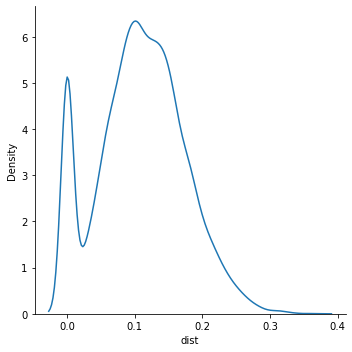

In [19]:
sns.displot(df, x='dist', kind='kde')

In [24]:
# add centroids to triplets
df_det['source'] = 'sample_det_centroid'
ca.triplets = pd.concat([ca.triplets, df_det], axis=0)

In [25]:
def plot_simplex_here(ca, gene):
    # det
    c_dict, order = get_biosample_colors()
    c_dict[np.nan] = 'k'
    mmap = {'v40': '*', 'v29': 'x', 'obs_det': '^', 'cerberus': '2', 'sample_det_centroid': 'x'} 
    subset = {'source': ['v40', 'obs_det', 'sample_det', 'sample_det_centroid']}
    fname='figures/simplex_{}_det.pdf'.format(gene.lower())
    df = ca.plot_simplex(top='splicing_ratio', 
                gene=gene,
                hue='sample',
                cmap=c_dict,
                density=True,
                density_scale=50,
                density_cmap='Purples',
                size='gene_tpm', 
                log_size=True,
                sectors=True,
                marker_style='source',
                mmap=mmap,
                legend=False,
                jitter=True,
                subset=subset,
                size_scale=0.5,
                fname=fname)  
    print(df.source.unique())

In [39]:
df.sort_values(by='dist', ascending=False).head(20)

,gname,gid,source_det,tss_ratio_det,tes_ratio_det,spl_ratio_det,n_iso_det,sector,gid_stable,biotype,...,n_tes,n_ic,n_iso_obs_det,splicing_ratio,tss_ratio_obs_det,tes_ratio_obs_det,spl_ratio_obs_det,sample,gene_tpm,dist
192,ACTA1,ENSG00000143632,sample_det,0.283798,0.283798,0.432405,2.894737,mixed,ENSG00000143632,protein_coding,...,1.0,18.0,18.0,18.000000,0.050000,0.050000,0.900000,NaN,NaN,0.363736
12431,RGP1,ENSG00000107185,sample_det,0.307969,0.410999,0.281033,1.466667,mixed,ENSG00000107185,protein_coding,...,8.0,1.0,8.0,0.222222,0.108434,0.867470,0.024096,NaN,NaN,0.360800
10178,NUFIP2,ENSG00000108256,sample_det,0.279224,0.454569,0.266207,2.026316,mixed,ENSG00000108256,protein_coding,...,12.0,3.0,13.0,0.461538,0.074286,0.891429,0.034286,NaN,NaN,0.344301
2579,CEBPA,ENSG00000245848,sample_det,0.424197,0.303367,0.272436,1.564103,mixed,ENSG00000245848,protein_coding,...,1.0,1.0,7.0,0.250000,0.848485,0.121212,0.030303,NaN,NaN,0.334538
16323,USP33,ENSG00000077254,sample_det,0.161016,0.268951,0.570033,8.306122,splicing,ENSG00000077254,protein_coding,...,6.0,21.0,21.0,2.800000,0.505618,0.337079,0.157303,NaN,NaN,0.332972
4033,DMTF1,ENSG00000135164,sample_det,0.278772,0.218234,0.502993,5.408163,splicing,ENSG00000135164,protein_coding,...,9.0,18.0,26.0,1.894737,0.478589,0.430730,0.090680,NaN,NaN,0.331555
4484,EIF4A2,ENSG00000156976,sample_det,0.145035,0.136955,0.718011,29.940000,splicing,ENSG00000156976,protein_coding,...,10.0,57.0,68.0,6.333333,0.328767,0.410959,0.260274,NaN,NaN,0.331405
8536,MAN2C1,ENSG00000140400,sample_det,0.238293,0.233760,0.527947,3.240000,splicing,ENSG00000140400,protein_coding,...,8.0,14.0,14.0,1.866667,0.415020,0.474308,0.110672,NaN,NaN,0.327179
1562,BRD8,ENSG00000112983,sample_det,0.142466,0.187644,0.669889,8.860000,splicing,ENSG00000112983,protein_coding,...,6.0,17.0,25.0,3.090909,0.354839,0.425806,0.219355,NaN,NaN,0.327035
6341,GSC,ENSG00000133937,sample_det,0.320802,0.365915,0.313283,1.285714,mixed,ENSG00000133937,protein_coding,...,5.0,1.0,5.0,0.333333,0.157895,0.789474,0.052632,NaN,NaN,0.324564


['v40' 'obs_det' 'sample_det' 'sample_det_centroid']


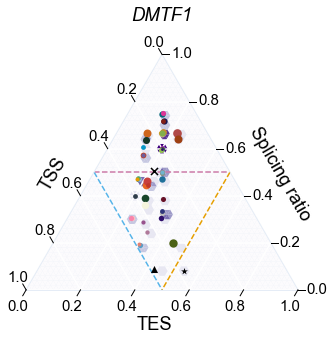

In [41]:
plot_simplex_here(ca, 'DMTF1')

In [46]:
ca.triplets.loc[(ca.triplets.gname=='DMTF1')&(ca.triplets.source=='sample_det')&(ca.triplets.spl_ratio>=0.5)]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,gname,sample,gene_tpm,sector,gid_stable,biotype
4906,sample_det,ENSG00000135164,1.0,1.0,4.0,4.0,4.000000,0.166667,0.166667,0.666667,DMTF1,caco2,13.876645,NaN,NaN,NaN
35553,sample_det,ENSG00000135164,1.0,1.0,6.0,6.0,6.000000,0.125000,0.125000,0.750000,DMTF1,mcf10a,24.474054,NaN,NaN,NaN
47542,sample_det,ENSG00000135164,2.0,1.0,6.0,6.0,4.000000,0.285714,0.142857,0.571429,DMTF1,a673,17.729202,NaN,NaN,NaN
61435,sample_det,ENSG00000135164,2.0,1.0,6.0,6.0,4.000000,0.285714,0.142857,0.571429,DMTF1,lung,9.986977,NaN,NaN,NaN
89966,sample_det,ENSG00000135164,2.0,1.0,8.0,8.0,5.333333,0.240000,0.120000,0.640000,DMTF1,colon,7.650995,NaN,NaN,NaN
105072,sample_det,ENSG00000135164,1.0,1.0,3.0,3.0,3.000000,0.200000,0.200000,0.600000,DMTF1,hmec,9.144121,NaN,NaN,NaN
142687,sample_det,ENSG00000135164,1.0,1.0,3.0,3.0,3.000000,0.200000,0.200000,0.600000,DMTF1,pgp1_astro,10.397375,NaN,NaN,NaN
155323,sample_det,ENSG00000135164,1.0,2.0,9.0,12.0,6.000000,0.111111,0.222222,0.666667,DMTF1,h9_de,118.622505,NaN,NaN,NaN
177796,sample_det,ENSG00000135164,1.0,1.0,2.0,2.0,2.000000,0.250000,0.250000,0.500000,DMTF1,pc9,12.042286,NaN,NaN,NaN
255214,sample_det,ENSG00000135164,1.0,1.0,5.0,5.0,5.000000,0.142857,0.142857,0.714286,DMTF1,ovary,24.268082,NaN,NaN,NaN


In [45]:
ca.triplets.loc[(ca.triplets.gname=='DMTF1')&(ca.triplets.source=='sample_det')&(ca.triplets.spl_ratio<0.5)]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,gname,sample,gene_tpm,sector,gid_stable,biotype
18809,sample_det,ENSG00000135164,4.0,3.0,8.0,8.0,2.285714,0.430769,0.323077,0.246154,DMTF1,brain,9.554504,NaN,NaN,NaN
77950,sample_det,ENSG00000135164,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,DMTF1,hl60_m0,15.593697,NaN,NaN,NaN
117163,sample_det,ENSG00000135164,3.0,3.0,8.0,8.0,2.666667,0.346154,0.346154,0.307692,DMTF1,k562,15.583178,NaN,NaN,NaN
130192,sample_det,ENSG00000135164,2.0,2.0,5.0,5.0,2.500000,0.307692,0.307692,0.384615,DMTF1,imr90,12.916826,NaN,NaN,NaN
166749,sample_det,ENSG00000135164,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,DMTF1,liver,4.584398,NaN,NaN,NaN
189520,sample_det,ENSG00000135164,4.0,5.0,10.0,14.0,2.222222,0.356436,0.445545,0.198020,DMTF1,h9_panc_progen,95.997871,NaN,NaN,NaN
200646,sample_det,ENSG00000135164,3.0,2.0,3.0,3.0,1.200000,0.483871,0.322581,0.193548,DMTF1,hl60_m2_24hr,13.517208,NaN,NaN,NaN
213256,sample_det,ENSG00000135164,3.0,2.0,3.0,3.0,1.200000,0.483871,0.322581,0.193548,DMTF1,vessels,8.204393,NaN,NaN,NaN
229293,sample_det,ENSG00000135164,3.0,2.0,10.0,10.0,4.000000,0.333333,0.222222,0.444444,DMTF1,h1,61.355434,NaN,NaN,NaN
242564,sample_det,ENSG00000135164,3.0,2.0,8.0,12.0,3.200000,0.365854,0.243902,0.390244,DMTF1,h9_neural_crest,55.633881,NaN,NaN,NaN


Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


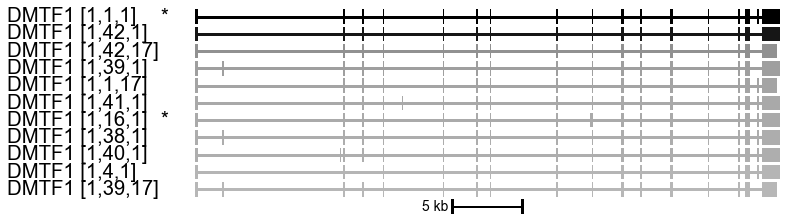

In [49]:
gene = 'DMTF1'
obs_col = 'sample'
obs_condition = 'h9'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                                         obs_col, obs_condition,
                                         filt_ab, major_set,
                                         h_space=0.24,
                                         h=0.2, ref_source='v40',
                                         major=False)

Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1817: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1816: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


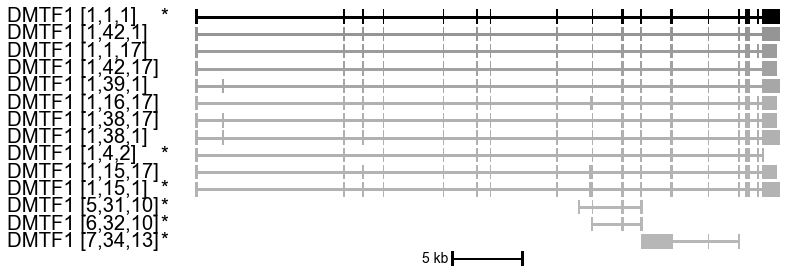

In [47]:
gene = 'DMTF1'
obs_col = 'sample'
obs_condition = 'h9_panc_progen'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                                         obs_col, obs_condition,
                                         filt_ab, major_set,
                                         h_space=0.24,
                                         h=0.2, ref_source='v40',
                                         major=False)

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


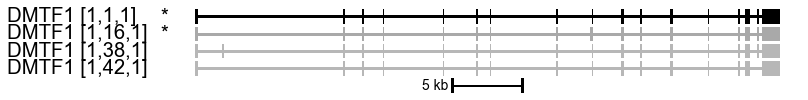

In [48]:
gene = 'DMTF1'
obs_col = 'sample'
obs_condition = 'h9_panc_beta'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                                         obs_col, obs_condition,
                                         filt_ab, major_set,
                                         h_space=0.24,
                                         h=0.2, ref_source='v40',
                                         major=False)

['v40' 'obs_det' 'sample_det' 'sample_det_centroid']


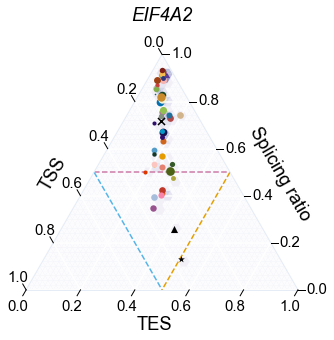

In [40]:
plot_simplex_here(ca, 'EIF4A2')

['v40' 'obs_det' 'sample_det' 'sample_det_centroid']


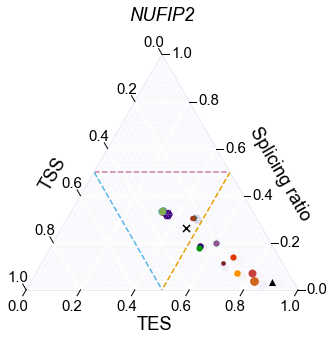

In [36]:
plot_simplex_here(ca, 'NUFIP2')

In [37]:
ca.triplets.loc[(ca.triplets.gname=='NUFIP2')&(ca.triplets.source=='sample_det')&(ca.triplets.tes_ratio>=0.5)]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,gname,sample,gene_tpm,sector,gid_stable,biotype
2535,sample_det,ENSG00000108256,1.0,4.0,1.0,4.0,0.400000,0.185185,0.740741,0.074074,NUFIP2,caco2,29.185089,NaN,NaN,NaN
33309,sample_det,ENSG00000108256,1.0,3.0,2.0,4.0,1.000000,0.200000,0.600000,0.200000,NUFIP2,mcf10a,22.670528,NaN,NaN,NaN
45201,sample_det,ENSG00000108256,1.0,4.0,2.0,5.0,0.800000,0.172414,0.689655,0.137931,NUFIP2,a673,25.246902,NaN,NaN,NaN
102796,sample_det,ENSG00000108256,1.0,3.0,1.0,3.0,0.500000,0.222222,0.666667,0.111111,NUFIP2,hmec,14.076232,NaN,NaN,NaN
114989,sample_det,ENSG00000108256,1.0,2.0,1.0,2.0,0.666667,0.272727,0.545455,0.181818,NUFIP2,k562,29.207054,NaN,NaN,NaN
226683,sample_det,ENSG00000108256,1.0,6.0,1.0,6.0,0.285714,0.137255,0.823529,0.039216,NUFIP2,h1,65.420929,NaN,NaN,NaN
267586,sample_det,ENSG00000108256,1.0,3.0,2.0,3.0,1.000000,0.200000,0.600000,0.200000,NUFIP2,gm12878,8.997055,NaN,NaN,NaN
304681,sample_det,ENSG00000108256,1.0,6.0,1.0,6.0,0.285714,0.137255,0.823529,0.039216,NUFIP2,wtc11,91.191643,NaN,NaN,NaN
340996,sample_det,ENSG00000108256,1.0,6.0,2.0,6.0,0.571429,0.132075,0.792453,0.075472,NUFIP2,h1_de,60.011559,NaN,NaN,NaN
365709,sample_det,ENSG00000108256,1.0,2.0,1.0,2.0,0.666667,0.272727,0.545455,0.181818,NUFIP2,calu3,24.497652,NaN,NaN,NaN


In [38]:
ca.triplets.loc[(ca.triplets.gname=='NUFIP2')&(ca.triplets.source=='sample_det')&(ca.triplets.tes_ratio<0.5)]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,gname,sample,gene_tpm,sector,gid_stable,biotype
16057,sample_det,ENSG00000108256,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,NUFIP2,brain,13.028910,NaN,NaN,NaN
58545,sample_det,ENSG00000108256,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,NUFIP2,lung,12.372070,NaN,NaN,NaN
87237,sample_det,ENSG00000108256,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,NUFIP2,colon,7.120804,NaN,NaN,NaN
127946,sample_det,ENSG00000108256,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,NUFIP2,imr90,31.861506,NaN,NaN,NaN
140303,sample_det,ENSG00000108256,1.0,2.0,2.0,2.0,1.333333,0.230769,0.461538,0.307692,NUFIP2,pgp1_astro,12.130270,NaN,NaN,NaN
153088,sample_det,ENSG00000108256,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,NUFIP2,h9_de,13.619748,NaN,NaN,NaN
175525,sample_det,ENSG00000108256,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,NUFIP2,pc9,14.623090,NaN,NaN,NaN
198770,sample_det,ENSG00000108256,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,NUFIP2,hl60_m2_24hr,27.158546,NaN,NaN,NaN
210633,sample_det,ENSG00000108256,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,NUFIP2,vessels,10.755004,NaN,NaN,NaN
240560,sample_det,ENSG00000108256,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,NUFIP2,h9_neural_crest,25.467564,NaN,NaN,NaN


['v40' 'obs_det' 'sample_det' 'sample_det_centroid']


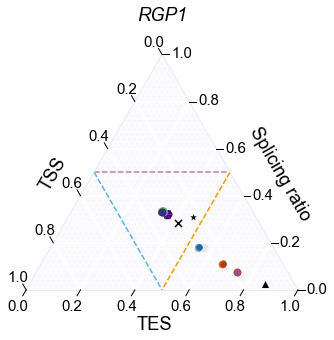

In [28]:
plot_simplex_here(ca, 'RGP1')

In [35]:
ca.triplets.loc[(ca.triplets.gname=='RGP1')&(ca.triplets.source=='sample_det')&(ca.triplets.tes_ratio>=0.5)].sort_values(by='tes_ratio', ascending=False)

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,gname,sample,gene_tpm,sector,gid_stable,biotype
304592,sample_det,ENSG00000107185,1.0,4.0,1.0,4.0,0.400000,0.185185,0.740741,0.074074,RGP1,wtc11,26.909401,NaN,NaN,NaN
340903,sample_det,ENSG00000107185,1.0,4.0,1.0,4.0,0.400000,0.185185,0.740741,0.074074,RGP1,h1_de,22.002939,NaN,NaN,NaN
487467,sample_det,ENSG00000107185,1.0,4.0,1.0,4.0,0.400000,0.185185,0.740741,0.074074,RGP1,hffc6,9.268376,NaN,NaN,NaN
153011,sample_det,ENSG00000107185,1.0,3.0,1.0,3.0,0.500000,0.222222,0.666667,0.111111,RGP1,h9_de,9.785069,NaN,NaN,NaN
226597,sample_det,ENSG00000107185,1.0,3.0,1.0,3.0,0.500000,0.222222,0.666667,0.111111,RGP1,h1,23.638510,NaN,NaN,NaN
500241,sample_det,ENSG00000107185,1.0,3.0,1.0,3.0,0.500000,0.222222,0.666667,0.111111,RGP1,h9,9.569843,NaN,NaN,NaN
2452,sample_det,ENSG00000107185,1.0,2.0,1.0,2.0,0.666667,0.272727,0.545455,0.181818,RGP1,caco2,14.051476,NaN,NaN,NaN
45123,sample_det,ENSG00000107185,1.0,2.0,1.0,2.0,0.666667,0.272727,0.545455,0.181818,RGP1,a673,8.068981,NaN,NaN,NaN
75921,sample_det,ENSG00000107185,1.0,2.0,1.0,2.0,0.666667,0.272727,0.545455,0.181818,RGP1,hl60_m0,6.703354,NaN,NaN,NaN
102720,sample_det,ENSG00000107185,1.0,2.0,1.0,2.0,0.666667,0.272727,0.545455,0.181818,RGP1,hmec,18.226398,NaN,NaN,NaN


In [31]:
ca.triplets.loc[(ca.triplets.gname=='RGP1')&(ca.triplets.source=='sample_det')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,gname,sample,gene_tpm,sector,gid_stable,biotype
2452,sample_det,ENSG00000107185,1.0,2.0,1.0,2.0,0.666667,0.272727,0.545455,0.181818,RGP1,caco2,14.051476,NaN,NaN,NaN
15967,sample_det,ENSG00000107185,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,RGP1,brain,12.130561,NaN,NaN,NaN
33235,sample_det,ENSG00000107185,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,RGP1,mcf10a,13.793271,NaN,NaN,NaN
45123,sample_det,ENSG00000107185,1.0,2.0,1.0,2.0,0.666667,0.272727,0.545455,0.181818,RGP1,a673,8.068981,NaN,NaN,NaN
58452,sample_det,ENSG00000107185,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,RGP1,lung,13.712227,NaN,NaN,NaN
75921,sample_det,ENSG00000107185,1.0,2.0,1.0,2.0,0.666667,0.272727,0.545455,0.181818,RGP1,hl60_m0,6.703354,NaN,NaN,NaN
87151,sample_det,ENSG00000107185,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,RGP1,colon,19.707832,NaN,NaN,NaN
102720,sample_det,ENSG00000107185,1.0,2.0,1.0,2.0,0.666667,0.272727,0.545455,0.181818,RGP1,hmec,18.226398,NaN,NaN,NaN
114916,sample_det,ENSG00000107185,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,RGP1,k562,12.764145,NaN,NaN,NaN
127869,sample_det,ENSG00000107185,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,RGP1,imr90,27.555897,NaN,NaN,NaN


Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1817: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1816: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


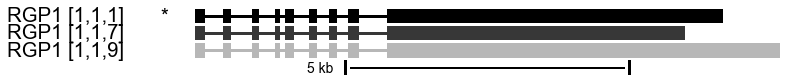

In [32]:
gene = 'RGP1'
obs_col = 'sample'
obs_condition = 'h1'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                                         obs_col, obs_condition,
                                         filt_ab, major_set,
                                         h_space=0.24,
                                         h=0.2, ref_source='v40',
                                         major=False)

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


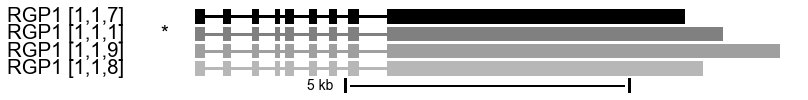

In [33]:
gene = 'RGP1'
obs_col = 'sample'
obs_condition = 'h1_de'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                                         obs_col, obs_condition,
                                         filt_ab, major_set,
                                         h_space=0.24,
                                         h=0.2, ref_source='v40',
                                         major=False)

['v40' 'obs_det' 'sample_det' 'sample_det_centroid']


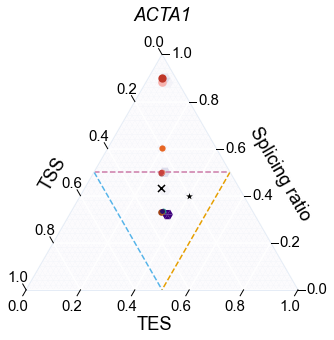

In [26]:
plot_simplex_here(ca, 'ACTA1')

['v40' 'obs_det' 'sample_det' 'sample_det_centroid']


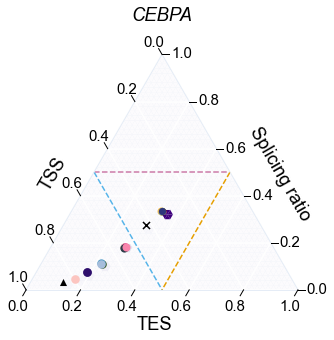

In [27]:
plot_simplex_here(ca, 'CEBPA')

## Which gene has the most diversity in terms of principal isoforms?

In [50]:
df = pd.read_csv('../swan/major_feats.tsv', sep='\t')
df.head()

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3427: DtypeWarning: Columns (0,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,tid,gid,sample,tid_pi,triplet_tpm,gid_stable,tss_id,tss_pi,tss_tpm,ic_id,ic_pi,ic_tpm,tes_id,tes_pi,tes_tpm,gname,tss,ic,tes,triplet
0,"ENSG00000285043[5,15,1]",ENSG00000285043,wtc11,95.81529,286.627000,ENSG00000285043,ENSG00000285043_5,96.392494,288.419980,ENSG00000285043_15,96.82539,290.004360,ENSG00000285043_1,99.783554,298.055240,ENSG00000285043,5,15,1,"5,15,1"
1,"ENSG00000285043[5,15,1]",ENSG00000285043,vessels,92.85714,245.049710,ENSG00000285043,ENSG00000285043_5,93.095240,245.509500,ENSG00000285043_15,94.64286,248.072740,ENSG00000285043_1,100.000000,265.761630,ENSG00000285043,5,15,1,"5,15,1"
2,"ENSG00000285043[5,15,1]",ENSG00000285043,pgp1_excite_neuron,81.53846,50.147280,ENSG00000285043,ENSG00000285043_5,83.076930,51.165703,ENSG00000285043_15,81.53846,50.147280,ENSG00000285043_1,100.000000,61.547830,ENSG00000285043,5,15,1,"5,15,1"
3,"ENSG00000285043[5,15,1]",ENSG00000285043,pgp1_endo,80.00000,54.699585,ENSG00000285043,ENSG00000285043_5,80.000000,54.699585,ENSG00000285043_15,80.00000,54.699585,ENSG00000285043_1,100.000000,67.684586,ENSG00000285043,5,15,1,"5,15,1"
4,"ENSG00000285043[5,15,1]",ENSG00000285043,pgp1_astro,85.31073,155.122470,ENSG00000285043,ENSG00000285043_5,85.875710,155.955410,ENSG00000285043_15,85.31073,155.122470,ENSG00000285043_1,100.000000,180.300810,ENSG00000285043,5,15,1,"5,15,1"


In [65]:
temp = df[['gid', 'gname', 'tid']].groupby(['gid', 'gname']).nunique().reset_index()

In [69]:
temp2 = df[['gid', 'gname', 'tid', 'sample']].groupby(['gid', 'gname', 'tid']).agg({'sample': ','.join}).reset_index()

In [66]:
temp.sort_values(by='tid', ascending=False)

,gid,gname,tid
2987,ENSG00000105483,CARD8,17
3499,ENSG00000109339,MAPK10,17
5524,ENSG00000126746,ZNF384,17
7238,ENSG00000138640,FAM13A,17
9611,ENSG00000159023,EPB41,16
...,...,...,...
7991,ENSG00000144015,TRIM43,0
1236,ENSG00000074855,ANO8,0
13188,ENSG00000179088,C12orf42,0
10996,ENSG00000166323,C11orf65,0


In [70]:
temp2.loc[temp2.gname=='MAPK10']

,gid,gname,tid,sample
11631,ENSG00000109339,MAPK10,"ENSG00000109339[1,1,2]",h9_panc_progen
11632,ENSG00000109339,MAPK10,"ENSG00000109339[1,1,5]",ocily7
11633,ENSG00000109339,MAPK10,"ENSG00000109339[1,38,5]",h1
11634,ENSG00000109339,MAPK10,"ENSG00000109339[1,42,1]",imr90
11635,ENSG00000109339,MAPK10,"ENSG00000109339[1,44,5]",h9_panc_beta
11636,ENSG00000109339,MAPK10,"ENSG00000109339[1,50,4]",caco2
11637,ENSG00000109339,MAPK10,"ENSG00000109339[1,54,5]","pgp1_excite_neuron,h9_neural_crest,adrenal gland"
11638,ENSG00000109339,MAPK10,"ENSG00000109339[25,99,5]","vessels,lung"
11639,ENSG00000109339,MAPK10,"ENSG00000109339[35,194,41]",brain
11640,ENSG00000109339,MAPK10,"ENSG00000109339[36,198,5]",h1_de


In [71]:
temp2.loc[temp2.gname=='CARD8']

,gid,gname,tid,sample
9976,ENSG00000105483,CARD8,"ENSG00000105483[1,1,2]","wtc11,hl60_m0"
9977,ENSG00000105483,CARD8,"ENSG00000105483[1,1,4]","ocily7,h9_panc_beta,h9_de"
9978,ENSG00000105483,CARD8,"ENSG00000105483[1,1,6]","vessels,imr90,hffc6,colon"
9979,ENSG00000105483,CARD8,"ENSG00000105483[1,10,7]","pgp1,pc9,panc1,mcf7,mcf10a,hmec,hl60_m1_24hr,h..."
9980,ENSG00000105483,CARD8,"ENSG00000105483[1,11,3]",heart
9981,ENSG00000105483,CARD8,"ENSG00000105483[1,37,4]","hl60_m2_72hr,h9_panc_progen,h9_osteocyte,h9_ch..."
9982,ENSG00000105483,CARD8,"ENSG00000105483[1,38,2]","pgp1_excite_neuron,h9_neural_crest,h1_de,h1,brain"
9983,ENSG00000105483,CARD8,"ENSG00000105483[1,8,2]",calu3
9984,ENSG00000105483,CARD8,"ENSG00000105483[1,8,6]","muscle,adipose"
9985,ENSG00000105483,CARD8,"ENSG00000105483[1,9,7]","pgp1_astro,caco2,adrenal gland"


['v40' 'obs_det' 'sample_det' 'sample_det_centroid']


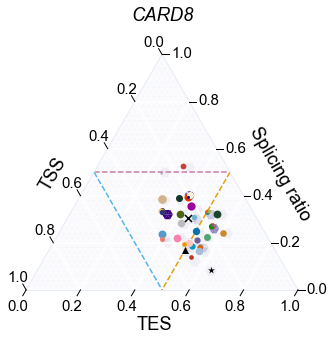

In [56]:
plot_simplex_here(ca, 'CARD8')

['v40' 'obs_det' 'sample_det' 'sample_det_centroid']


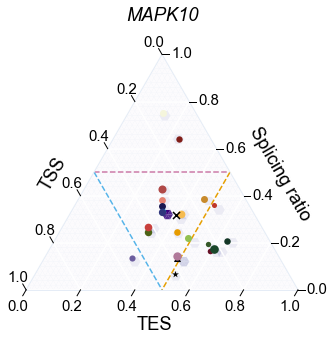

In [57]:
plot_simplex_here(ca, 'MAPK10')

In [73]:
# def plot_tss(ca, sg, tpm_df, x, y, h, ax):
#     tpm_df = add_feat(tpm_df, kind='tss', col='transcript_id')
#     tpm_df.head()
#     tss_df = ca.tss.loc[ca.tss.Name.isin(tpm_df.tss.tolist())]
#     tss_df.head()
#     regions = [(entry.Start, entry.End) for ind, entry in tss_df.iterrows()]
#     color = get_sector_colors()[0]['tss']
#     ax = sg.pg.plot_regions(regions, sg.pg.scale, sg.pg.strand, sg.pg.g_min, sg.pg.g_max, x, y, h, color, ax)
#     return ax

# def plot_ccre(ca, sg, x, y, h, ax):

#     # ccre regions
#     sources = ['pls', 'pels', 'dels']
#     ccre = ca.tss_map.loc[ca.tss_map.source.isin(sources)].copy(deep=True)

#     # get ranges w/i this region
#     min_coord = sg.pg.g_min
#     max_coord = sg.pg.g_max
#     chrom = sg.pg.chrom

#     ccre['min_coord'] = ccre[['Start', 'End']].min(axis=1)
#     ccre['max_coord'] = ccre[['Start', 'End']].max(axis=1)

#     # subset on regions 
#     ccre = pr.PyRanges(ccre)
#     region = pr.from_dict({'Chromosome': [chrom],
#                                     'Start': [min_coord],
#                                     'End': [max_coord]})
#     # ccre = ccre.intersect(region, strandedness=None, how='containment')
#     ccre = ccre.intersect(region, strandedness=None)
#     ccre = ccre.as_df()

#     # colors
#     c_dict, _ = get_ccre_colors()
#     colors = [c_dict[s] for s in ccre.source.tolist()]
#     regions = [(entry.Start, entry.End) for ind, entry in ccre.iterrows()]
#     ax = sg.pg.plot_regions(regions, sg.pg.scale, sg.pg.strand, sg.pg.g_min, sg.pg.g_max, x, y, h, colors, ax)

#     return ax

# def get_major_isos(major_set, gene, sample=None):
#     """
#     Get list of major isfoorms in a given sample
#     """
#     df = pd.read_csv(major_set, sep='\t')
#     df = df.loc[df.gname == gene]
#     if sample:
#         df = df.loc[df['sample'] == sample]
#     tids = df.tid.unique().tolist()
#     return tids

# def get_isos(ca, filt_ab, gene, sample):
#     df = pd.read_csv(filt_ab, sep='\t')
#     df = get_det_table(df,
#                    groupby='sample',
#                    how='iso',
#                    min_tpm=1,
#                    gene_subset='polya',
#                    species=species)
#     df = df.loc[sample]
#     df = df.to_frame()
#     df = df.loc[df[sample]==True]
#     gid = ca.triplets.loc[ca.triplets.gname==gene, 'gid'].values[0]
#     df.reset_index(inplace=True)
#     df['gid'] = df['index'].str.split('[', expand=True)[0]
#     df = df.loc[df.gid == gid]
#     tids = df['index'].tolist()
#     return tids


# def get_tpm_df(sg, tids, obs_col, obs_condition):
#     # get tpm df
#     tpm_df = swan.calc_tpm(sg.adata, obs_col=obs_col).sparse.to_dense()
#     tpm_df = tpm_df.transpose()
#     tpm_df = tpm_df.loc[tids, obs_condition].to_frame()
#     return tpm_df

In [72]:
# def plot_browser_principal_isos(ca, tids,
#                   h=0.1, w=56, x=14, fig_w=14,
#                   ref_source='v40', species='human',
#                   h_space=None,
#                   add_tss=False, add_ccre=False):
#     """
#     Plot browser style isoform models for a given sample
#     """
    
#     # font sizes
#     # small_text = 6/(6.11/16)
#     small_text = 20.3
#     big_text = 6.71/(6.11/16)
#     print('small text size: {}'.format(small_text))
#     print('big text size: {}'.format(big_text))
    
    
#     # height spacing b/w models
#     if not h_space:
#         h_space = h*1.75
#     # print('h_space : {}'.format(h_space))
#     # print('h: {}'.format(h))
    
#     # plotting settings
#     fig_len = len(tids)
#     fig_len += 1 # for scale
#     if add_tss: 
#         fig_len += 1
#     if add_ccre:
#         fig_len += 1
#     fig_h = h_space*(fig_len-1)+h
#     fig_h += 0.3 # vertical spacing adjustment
#     # print('fig h: {}'.format(fig_h))
#     # print('fig w: {}'.format(fig_w))
#     plt.figure(1, figsize=(fig_w, fig_h), frameon=False)
#     mpl.rcParams['font.family'] = 'Arial'
#     mpl.rcParams['pdf.fonttype'] = 42
#     ax = plt.gca()
    
#     # x coords for gencode name and cerberus name
#     x_gc = -4
#     x_c = 11
    
#     # add reference ids
#     tpm_df = tpm_df.to_frame()
#     df = ca.t_map.loc[ca.t_map.source == ref_source]
#     df = df[['transcript_id','original_transcript_id', 'original_transcript_name']]
#     tpm_df = tpm_df.merge(df, how='left', left_index=True, right_on='transcript_id')

#     # clean up for transcripts that aren't known
#     df = ca.t_map.loc[ca.t_map.source == 'lapa']
#     df = df[['gene_name', 'transcript_id', 'transcript_name',
#              'tss_id', 'ic_id', 'tes_id']].drop_duplicates()
#     tpm_df = tpm_df.merge(df, how='left', on='transcript_id')
#     tpm_df.fillna('N/A', inplace=True)
    
#     # label known transcripts with a * 
#     tpm_df['Known'] = ''
#     tpm_df = tpm_df.copy(deep=True)
#     tpm_df = tpm_df.merge(ca.ic[['Name', 'novelty']], how='left', left_on='ic_id', right_on='Name')
#     tpm_df.rename({'novelty':'ic_novelty'}, axis=1, inplace=True)
#     tpm_df.drop('Name', axis=1, inplace=True)
#     tpm_df = tpm_df.merge(ca.tss[['Name', 'novelty']], how='left', left_on='tss_id', right_on='Name')
#     tpm_df.rename({'novelty':'tss_novelty'}, axis=1, inplace=True)
#     tpm_df.drop('Name', axis=1, inplace=True)
#     tpm_df = tpm_df.merge(ca.tes[['Name', 'novelty']], how='left', left_on='tes_id', right_on='Name')
#     tpm_df.rename({'novelty':'tes_novelty'}, axis=1, inplace=True)
#     tpm_df.drop('Name', axis=1, inplace=True)
#     # tpm_df.loc[(tpm_df.tss_novelty=='Known')&\
#     #            (tpm_df.ic_novelty=='Known')&\
#     #            (tpm_df.tes_novelty=='Known'), 'Known'] = '*'
#     if species == 'human':
#         refs = ['v40', 'v29']
#     elif species == 'mouse':
#         refs = ['vM21', 'vM25']
#     known_tids = ca.t_map.loc[ca.t_map.source.isin(refs)].transcript_id.unique().tolist()
#     tpm_df.loc[tpm_df.transcript_id.isin(known_tids), 'Known'] = '*'
    
#     # triplets rather than entire transcript name
#     tpm_df['triplet'] = tpm_df.transcript_id.str.split('[', n=1, expand=True)[1]
#     tpm_df['triplet'] = tpm_df.triplet.str.split(']', n=1, expand=True)[0]
#     tpm_df['triplet'] = '['+tpm_df.triplet+']'
    
#     i = 0
#     # print('h: {}'.format(h))
#     for index, entry in tpm_df.iterrows():
        
#         # y coords
#         y = (len(tpm_df.index) - i)*(h_space)
#         y_text = y+(h/2)
        
#         # tid
#         tid = entry['transcript_id']
#         gname = entry['gene_name']
#         tname = entry['transcript_name']
#         ref_tname = entry['original_transcript_name']
#         trip = entry['triplet'] 
#         iso_trip = '{} {}'.format(gname, trip)
#         known = entry['Known']
    
#         # color by TPM
#         if len(tpm_df.index) == 1:
#             norm_val = entry[obs_condition]
#         else:
#             norm_val = (entry[obs_condition]-tpm_df[obs_condition].min())/(tpm_df[obs_condition].max()-tpm_df[obs_condition].min())
#         color = cmap(norm_val)
#         ax = sg.plot_browser(tid, y=y, x=x, h=h, w=w, color=color, ax=ax) 
#         # print('transcipt #{}, {}, y = {}'.format(i, iso_trip, y))

#        # isoform name / novelty
#         ax.text(x_c, y_text, known,
#                 verticalalignment='center', 
#                 horizontalalignment='center',
#                 size=small_text)   
#         ax.text(x_gc, y_text, iso_trip,
#                 verticalalignment='center',
#                 horizontalalignment='left', 
#                 size=small_text) 
        
#         i += 1
        
#     # label the different columns
#     # y = (len(tpm_df.index)+1)*(h_space)
#    # # ax.text(x_c, y+(h/2), 'Cerberus Name',
#     ##     verticalalignment='center', 
#     ##     horizontalalignment='center')    
#     ## ax.text(x_gc,y+(h/2), 'GENCODE v40 Name',
#     ##         verticalalignment='center',
#           #  # horizontalalignment='center')
    
#     # ax.text(x_c, y+(h/2), 'Known',
#     #     verticalalignment='center', 
#     #     horizontalalignment='center', 
#     #     size=big_text)    
#     # ax.text(x_gc,y+(h/2), 'Isoform triplet',
#     #         verticalalignment='center',
#     #         horizontalalignment='center',
#     #         size=big_text)   
    
    
#     i = len(tpm_df.index)
#     if add_tss:
#         y = (len(tpm_df.index) - i)*(h_space)
#         ax = plot_tss(ca, sg, tpm_df, x, y, h, ax)
#         i += 1
    
#     if add_ccre:
#         y = (len(tpm_df.index) - i)*(h_space)
#         ax = plot_ccre(ca, sg, x, y, h, ax)
#         i += 1
        
#     # add scale
#     y = (len(tpm_df.index) - i)*(h_space)
#     # print('y scale: {}'.format(y))
#     ax = sg.pg.plot_scale(x, y, h, 14, ax)
        
#     # remove axes
#     plt.axis('off')
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False) 
#     plt.tight_layout()
    
#     # set x / y lim
#     y_max = (len(tpm_df.index) - 0)*(h_space)+h
#     y_min = y
#     plt.ylim((y_min,y_max))
#     plt.xlim((-4, 72))
#     # print('ylim: ({},{})'.format(y_min,y_max))
    
#     return ax, tpm_df

## Compare overall distribution of triplet features / gene w/ sample-level dists

In [3]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus
import subprocess
from pandarallel import pandarallel

p = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [8]:
major_set = '../swan/isos_sample_gene_90.tsv'
c_annot = 'cerberus_annot_triplets.h5'
gtf = '../cerberus.gtf'
swan_file = '../swan/swan.p'
filt_ab = '../cerberus_filtered_abundance.tsv'
h5 = '../cerberus_annot.h5'
feat = 'tss'
obs_source = 'lapa'
ref_sources = ['v40', 'v29']

fig_dir = '/Users/fairliereese/mortazavi_lab/documents/rnawg/fig4'

In [4]:
sg = swan.read(swan_file)
ca = cerberus.read(c_annot)

Read in graph from ../swan/swan.p


In [59]:
def get_counts_per_gene(filt_ab, obs_col, feat, min_tpm, gene_subset):
    # counts per gene
    df = pd.read_csv(filt_ab, sep='\t')
    df = get_det_table(df,
                        groupby=obs_col,
                        how=feat, 
                        gene_subset=gene_subset,
                        min_tpm=min_tpm)

    df = df.transpose()
    df.reset_index(inplace=True)
    df.rename({'index':'feat_id'}, axis=1, inplace=True)
    df['gid'] = df.feat_id.str.split('_', expand=True)[0]
    df = df[['gid', 'feat_id']].groupby('gid').count().reset_index()
    df.rename({'feat_id': 'counts'}, axis=1, inplace=True)
    
    return df

In [66]:
def get_counts_per_sample_per_gene(filt_ab, obs_col, feat, min_tpm, gene_subset):
    
    # counts per sample per gene
    df = pd.read_csv(filt_ab, sep='\t')
    df = get_det_table(df,
                        groupby=obs_col,
                        how=feat, 
                        gene_subset=gene_subset,
                        min_tpm=min_tpm)

    df = df.melt(var_name='feat_id', value_name='det', ignore_index=False)
    df.reset_index(inplace=True)
    df.rename({'index': obs_col}, axis=1, inplace=True)
    df = df.loc[df.det == True]
    df.drop('det', axis=1, inplace=True)

    df['gid'] = df.feat_id.str.split('_', expand=True)[0]
    df = df.groupby(['biosample', 'gid']).count().reset_index()
    df.rename({'feat_id': 'counts'}, axis=1, inplace=True)
    
    return df

In [82]:
def plot_feats_per_sample_gene(temp, feat):
    sns.set_context('paper', font_scale=2)
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['pdf.fonttype'] = 42
    c_dict, order = get_feat_colors()
    # temp1 = temp.loc[temp.source=='Observed']
    # ax = sns.kdeplot(data=temp, x='counts', hue='feat', palette=c_dict, common_norm=False, linewidth=3)
    # temp1 = temp.loc[temp.source=='Sample']
    # sns.kdeplot(data=temp, x='counts', hue='feat', palette=c_dict, linestyle='--', common_norm=False, linewidth=3, ax=ax)
    sns.kdeplot(data=temp, x='counts', hue='feat', palette=c_dict, linestyle='--', common_norm=False, linewidth=3, ax=ax)

    label_feat = feat.upper()
    xlabel = f'# {label_feat}s'
    ylabel = 'Density'

    # xlim = (0,20)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    
    fname = f'figures/{feat}s_per_sample_gene.pdf'
    plt.savefig(fname, dpi=500)

Calculating tss TPM values
Subsetting for protein_coding genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1817: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1816: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # tsss detected: 76487
# tsss >= 1 tpm: 67730
Applying gene type and novelty subset
Number of tsss reported: 53051
Found 50 total samples
Calculating tss TPM values
Subsetting for protein_coding genes
Enforcing minimum TPM
Total # tsss detected: 76487
# tsss >= 1 tpm: 67730
Applying gene type and novelty subset
Number of tsss reported: 53051
Found 50 total samples


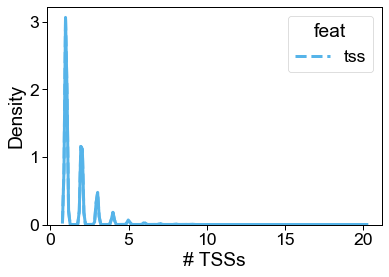

In [84]:
obs_col = 'sample'
min_tpm = 1
gene_subset = 'protein_coding'

df = pd.DataFrame()
for feat in ['tss', 'ic', 'tes']:

    g_counts = get_counts_per_gene(filt_ab, obs_col, feat, min_tpm, gene_subset)
    gs_counts = get_counts_per_sample_per_gene(filt_ab, obs_col, feat, min_tpm, gene_subset)

    g_counts['source'] = 'Observed'
    g_counts['feat'] = feat
    gs_counts['source'] = 'Sample'
    gs_counts['feat'] = feat
    
    temp = pd.concat([g_counts, gs_counts], axis=0)
    plot_feats_per_sample_gene(temp, feat)
    
    df = pd.concat([df, temp], axis=0)   
    break

In [118]:
temp.head()

,gid,counts,source,feat,biosample
0,ENSG00000000003,1,Observed,tss,NaN
1,ENSG00000000005,1,Observed,tss,NaN
2,ENSG00000000419,2,Observed,tss,NaN
3,ENSG00000000457,3,Observed,tss,NaN
4,ENSG00000000460,3,Observed,tss,NaN


In [159]:
def renum_max_feats(temp, col, max_val):
    """
    Parameters:
        temp (df): DataFrame
        col (str): Col to transform
        max_val (int): Max value
    """
    max_str = '{}+'.format(max_val)
    temp['rank'] = temp[col].astype(int).astype(str)
    temp.loc[temp[col]>=max_val, 'rank'] = max_str
    order = [str(int(i)) for i in range(1,max_val)]
    order += [max_str]
    return temp, order, 'rank'

In [167]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

<Figure size 216x288 with 0 Axes>

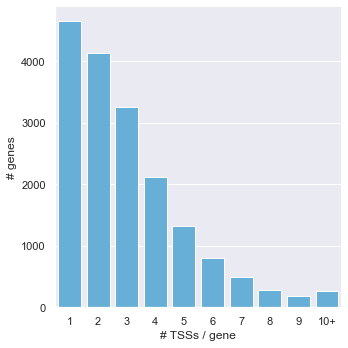

In [169]:
# label info
x_hr = feat.upper()

# color info
c_dict, order = get_feat_colors()
color = c_dict[feat]

# observed overall feats / gene
plt.figure(figsize=(3,4))
temp1 = temp.loc[temp.source == 'Observed']
temp1, order, col = renum_max_feats(temp1, 'counts', 10)
temp1 = temp1[[col, 'gid']].groupby([col]).count().reset_index()
temp1.rename({'gid': 'n_feats'}, axis=1, inplace=True)
ax = sns.catplot(data=temp1, y='n_feats', x=col, kind='bar', edgecolor=None, alpha=1, color=color, order=order)
xlabel = f'# {x_hr}s / gene'
ylabel = '# genes'
ax.set(xlabel=xlabel, ylabel=ylabel)

In [162]:
temp1.head()

,rank,n_feats
0,1,4656
1,10+,265
2,2,4128
3,3,3257
4,4,2123


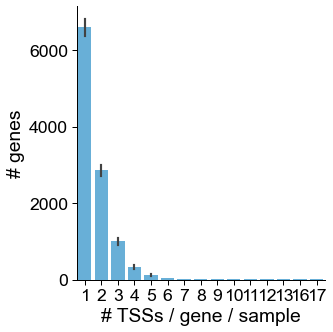

In [140]:
# feats / sample / gene
temp1 = temp.loc[temp.source == 'Sample']
temp1 = temp1[['counts', 'biosample', 'gid']].groupby(['counts', 'biosample']).count().reset_index()
temp1.rename({'gid': 'n_feats'}, axis=1, inplace=True)
ax = sns.catplot(data=temp1, y='n_feats', x='counts', kind='bar', edgecolor=None, alpha=1, color=color)
xlabel = f'# {x_hr}s / gene / {obs_col}'
ylabel = '# genes'
ax.set(xlabel=xlabel, ylabel=ylabel)

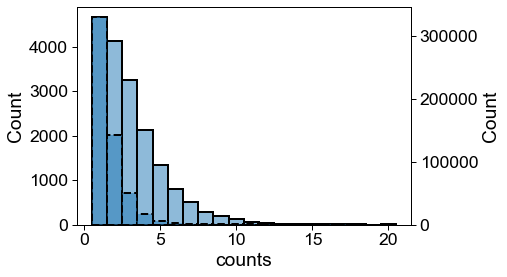

In [103]:
# temp1 = temp.loc[temp.source=='Observed']
# temp1['counts_scaled'] = temp.counts / temp.counts
# ax = sns.histplot(data=temp1, x='counts', binwidth=1, alpha=0.5, linewidth=2, discrete=True)
# ax2 = ax.twinx()
# temp2 = temp.loc[temp.source=='Sample']
# sns.histplot(data=temp2, x='counts', binwidth=1, alpha=0.5, ax=ax2, linewidth=2, linestyle='--', discrete=True)
# # ax = sns.kdeplot(data=temp, x='counts', hue='feat', palette=c_dict, linestyle='--', common_norm=False, linewidth=3, levels=2)

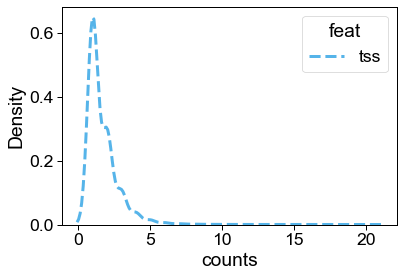

In [94]:
ax = sns.kdeplot(data=temp, x='counts', hue='feat', palette=c_dict, linestyle='--', common_norm=False, linewidth=3, bw_adjust=5)

[Text(0, 0.5, 'Density'), (0.0, 20.0), Text(0.5, 0, '# triplet features')]

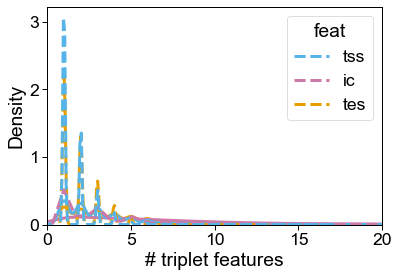

In [75]:
# sns.set_context('paper', font_scale=2)
# mpl.rcParams['font.family'] = 'Arial'
# mpl.rcParams['pdf.fonttype'] = 42
# c_dict, order = get_feat_colors()
# temp = df.loc[df.source=='Observed']
# ax = sns.kdeplot(data=temp, x='counts', hue='feat', palette=c_dict, common_norm=False, linewidth=3)
# temp = df.loc[df.source=='Sample']
# sns.kdeplot(data=temp, x='counts', hue='feat', palette=c_dict, linestyle='--', common_norm=False, linewidth=3, ax=ax)

# ax = plt.gca()
# xlabel = '# triplet features'
# ylabel = 'Density'

# xlim = (0,20)
# ax.set(xlabel=xlabel, ylabel=ylabel, xlim=xlim)

Calculating tss TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1817: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1816: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # tsss detected: 76487
# tsss >= 1 tpm: 67730
Applying gene type and novelty subset
Number of tsss reported: 64664
Found 50 total samples
